### The goal of this notebook is to combine the 3 perspectives that were created in order to obtain final clusters that characterize the customers and allow the definition of marketing strategies.

The four perspectives are:

- Behavioral
- Loyalty
- Value Based

In [1]:
import pandas as pd
import numpy as np
# Custom Modules
import sys

from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import RobustScaler

In [2]:
df = pd.read_csv("df_ready_for_clustering.csv")
df.head()

,PointsRedeemedRatio,FlightsWithCompanionsRatio,AvgDistancePerFlight,KMPerRedeemedPoint,UnredeemedPoints,HasBonus,AvgMonthlyFlights,sr_jan,sr_feb,sr_mar,...,Education,Income,Marital Status,LoyaltyStatus,EnrollmentMonth,Time on Program,Cancelled,Reenroll,EnrollmentType,Customer Lifetime Value
0,0.387904,0.200000,2356.577778,25.786888,32446,0,6.250000,0.026667,0.040000,0.146667,...,Bachelor,82877.0,Married,Aurora,8,874,N,0,Standard,7919.20
1,0.553363,0.224490,1384.141224,18.077435,15141,0,6.805556,0.077551,0.024490,0.114286,...,College,0.0,Single,Nova,3,2122,N,0,Standard,2887.74
2,0.113362,0.241706,2047.539336,88.241585,38293,0,5.861111,0.094787,0.000000,0.066351,...,College,0.0,Divorced,Nova,7,884,N,0,Standard,2838.07
3,0.354092,0.157407,3375.941667,28.248369,23544,0,3.000000,0.000000,0.111111,0.027778,...,Bachelor,42837.0,Married,Star,8,1242,N,0,Standard,4170.57
4,0.253580,0.276243,2373.649171,39.448214,32058,0,5.027778,0.022099,0.027624,0.165746,...,Bachelor,80979.0,Divorced,Star,1,1816,N,0,Standard,6622.05


In [3]:
df.columns

Index(['PointsRedeemedRatio', 'FlightsWithCompanionsRatio',
       'AvgDistancePerFlight', 'KMPerRedeemedPoint', 'UnredeemedPoints',
       'HasBonus', 'AvgMonthlyFlights', 'sr_jan', 'sr_feb', 'sr_mar', 'sr_apr',
       'sr_may', 'sr_jun', 'sr_jul', 'sr_aug', 'sr_sep', 'sr_oct', 'sr_nov',
       'sr_dec', 'Province or State', 'Education', 'Income', 'Marital Status',
       'LoyaltyStatus', 'EnrollmentMonth', 'Time on Program', 'Cancelled',
       'Reenroll', 'EnrollmentType', 'Customer Lifetime Value'],
      dtype='object')

In [4]:
# Define column types
binary_columns = ['EnrollmentType', 'Cancelled']
frequency_column = 'Province or State'
onehot_columns = ['CustomerSegment', 'Education', 'Marital Status', 'LoyaltyStatus']

# Get numerical columns (exclude categorical, datetime, and timedelta columns)
all_categorical = binary_columns + [frequency_column] + onehot_columns

# Identify datetime and timedelta columns to exclude
datetime_cols = df.select_dtypes(include=['datetime64', 'timedelta64']).columns.tolist()

# Get only numeric columns that are not categorical or datetime
numerical_cols = df.select_dtypes(include=['int64', 'float64', 'int32', 'float32']).columns.tolist()
numerical_cols = [col for col in numerical_cols if col not in all_categorical]

# 1. MINMAX SCALING on numerical columns directly in df
if len(numerical_cols) > 0:
    scaler = MinMaxScaler()
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# 2. BINARY ENCODING directly in df
#for col in binary_columns:
#    if col in df.columns:
#        df[col] = (df[col] == df[col].unique()[1]).astype(int)

# Frequency encoding
#if frequency_column in df.columns:
#    freq_map = df[frequency_column].value_counts(normalize=True)
#    df[frequency_column] = df[frequency_column].map(freq_map)

# 4. ONE-HOT ENCODING directly in df
#for col in onehot_columns:
#    if col in df.columns:
#        dummies = pd.get_dummies(df[col], prefix=col, drop_first=True)
#        dummies = dummies.astype(int)
#        df.drop(col, axis=1, inplace=True)
#        for dummy_col in dummies.columns:
#            df[dummy_col] = dummies[dummy_col]

# 5. CONVERT ALL REMAINING BOOLEAN COLUMNS TO INT
#bool_cols = df.select_dtypes(include=['bool']).columns.tolist()
#if len(bool_cols) > 0:
 #   df[bool_cols] = df[bool_cols].astype(int)

#print("\n" + "="*60)
#print(f"Transformation complete")
#print(f"Final df shape: {df.shape}")
#print(f"Datetime columns kept as-is: {datetime_cols}")
#print(f"NaN count: {df.isnull().sum().sum()}")
#print(f"\nData types in df:")
#print(df.dtypes.value_counts())
df.head()

,PointsRedeemedRatio,FlightsWithCompanionsRatio,AvgDistancePerFlight,KMPerRedeemedPoint,UnredeemedPoints,HasBonus,AvgMonthlyFlights,sr_jan,sr_feb,sr_mar,...,Education,Income,Marital Status,LoyaltyStatus,EnrollmentMonth,Time on Program,Cancelled,Reenroll,EnrollmentType,Customer Lifetime Value
0,0.011660,0.200000,0.053732,0.101416,0.497569,0.0,0.655977,0.026667,0.040000,0.146667,...,Bachelor,0.828927,Married,Aurora,0.636364,0.354564,N,0.0,Standard,0.073946
1,0.016634,0.224490,0.031560,0.071096,0.232192,0.0,0.714286,0.077551,0.024490,0.114286,...,College,0.000000,Single,Nova,0.181818,0.860852,N,0.0,Standard,0.012155
2,0.003408,0.241706,0.046686,0.347041,0.587235,0.0,0.615160,0.094787,0.000000,0.066351,...,College,0.000000,Divorced,Nova,0.545455,0.358621,N,0.0,Standard,0.011545
3,0.010644,0.157407,0.076975,0.111097,0.361054,0.0,0.314869,0.000000,0.111111,0.027778,...,Bachelor,0.428451,Married,Star,0.636364,0.503854,N,0.0,Standard,0.027909
4,0.007622,0.276243,0.054122,0.155144,0.491619,0.0,0.527697,0.022099,0.027624,0.165746,...,Bachelor,0.809944,Divorced,Star,0.000000,0.736714,N,0.0,Standard,0.058015


## Value Based and Loyalty

In [5]:
value_based_cluster = pd.read_csv("value_based_clusters.csv")
value_based_cluster.head()

,kr3_cluster
0,0
1,0
2,1
3,0
4,0


In [6]:
loyalty_cluster = pd.read_csv("loyalty_cluster.csv")
loyalty_cluster.drop(columns=['Unnamed: 0'], inplace=True)
loyalty_cluster.head()

,kmeans_cluster
0,2
1,0
2,2
3,1
4,0


In [18]:
# VB_col is the list of columns related to value-based perspective
VB_col = [

    'Customer Lifetime Value',
    'UnredeemedPoints',
    'PointsRedeemedRatio',
    'KMPerRedeemedPoint'
]

LO_col = [ 'Time on Program', 'EnrollmentMonth']


In [19]:
df["VALUE_BASED_CLUSTER"] = value_based_cluster["kr3_cluster"]
df["LOYALTY_CLUSTER"] = loyalty_cluster["kmeans_cluster"]
df.head()

,PointsRedeemedRatio,FlightsWithCompanionsRatio,AvgDistancePerFlight,KMPerRedeemedPoint,UnredeemedPoints,HasBonus,AvgMonthlyFlights,sr_jan,sr_feb,sr_mar,...,Marital Status,LoyaltyStatus,EnrollmentMonth,Time on Program,Cancelled,Reenroll,EnrollmentType,Customer Lifetime Value,VALUE_BASED_CLUSTER,LOYALTY_CLUSTER
0,0.011660,0.200000,0.053732,0.101416,0.497569,0.0,0.655977,0.026667,0.040000,0.146667,...,Married,Aurora,0.636364,0.354564,N,0.0,Standard,0.073946,0,2
1,0.016634,0.224490,0.031560,0.071096,0.232192,0.0,0.714286,0.077551,0.024490,0.114286,...,Single,Nova,0.181818,0.860852,N,0.0,Standard,0.012155,0,0
2,0.003408,0.241706,0.046686,0.347041,0.587235,0.0,0.615160,0.094787,0.000000,0.066351,...,Divorced,Nova,0.545455,0.358621,N,0.0,Standard,0.011545,1,2
3,0.010644,0.157407,0.076975,0.111097,0.361054,0.0,0.314869,0.000000,0.111111,0.027778,...,Married,Star,0.636364,0.503854,N,0.0,Standard,0.027909,0,1
4,0.007622,0.276243,0.054122,0.155144,0.491619,0.0,0.527697,0.022099,0.027624,0.165746,...,Divorced,Star,0.000000,0.736714,N,0.0,Standard,0.058015,0,0


In [20]:
print(df.columns.tolist())


['PointsRedeemedRatio', 'FlightsWithCompanionsRatio', 'AvgDistancePerFlight', 'KMPerRedeemedPoint', 'UnredeemedPoints', 'HasBonus', 'AvgMonthlyFlights', 'sr_jan', 'sr_feb', 'sr_mar', 'sr_apr', 'sr_may', 'sr_jun', 'sr_jul', 'sr_aug', 'sr_sep', 'sr_oct', 'sr_nov', 'sr_dec', 'Province or State', 'Education', 'Income', 'Marital Status', 'LoyaltyStatus', 'EnrollmentMonth', 'Time on Program', 'Cancelled', 'Reenroll', 'EnrollmentType', 'Customer Lifetime Value', 'VALUE_BASED_CLUSTER', 'LOYALTY_CLUSTER']


Since we discovered, previously, that VIP customers were the ones in cluster 3 on value based cluster, for the merging we are not going to use and we will deal with them separate.

In [21]:
df_no_vip = df[df['VALUE_BASED_CLUSTER'] != 3].copy()


In [22]:
# Centroids of the concatenated cluster labels
df_centroids = df_no_vip.groupby(['VALUE_BASED_CLUSTER', 'LOYALTY_CLUSTER'])\
    [VB_col + LO_col].mean()
df_centroids

Customer Lifetime Value  \
VALUE_BASED_CLUSTER LOYALTY_CLUSTER                            
0                   0                               0.074188   
                    1                               0.071821   
                    2                               0.073557   
1                   0                               0.067447   
                    1                               0.072975   
                    2                               0.076200   
2                   0                               0.100979   
                    1                               0.101841   
                    2                               0.093541   

                                     UnredeemedPoints  PointsRedeemedRatio  \
VALUE_BASED_CLUSTER LOYALTY_CLUSTER                                          
0                   0                        0.315863             0.008668   
                    1                        0.399819             0.008816   
                    2                        0.210498             0.008555   
1                   0                        0.337109             0.008065   
                    1                        0.415875             0.008487   
                    2                        0.231130             0.008984   
2                   0                        0.327870             0.008669   
                    1                        0.395803             0.008516   
                    2                        0.209078             0.008804   

                                     KMPerRedeemedPoint  Time on Program  \
VALUE_BASED_CLUSTER LOYALTY_CLUSTER                                        
0                   0                          0.106658         0.385391   
                    1                          0.136785         0.772403   
                    2                          0.072175         0.193032   
1                   0                          0.130852         0.392170   
                    1                          0.155880         0.767440   
                    2                          0.089924         0.194553   
2                   0                          0.121747         0.381582   
                    1                          0.143911         0.778289   
                    2                          0.074576         0.198596   

                                     EnrollmentMonth  
VALUE_BASED_CLUSTER LOYALTY_CLUSTER                   
0                   0                       0.189189  
                    1                       0.656171  
                    2                       0.757335  
1                   0                       0.188185  
                    1                       0.671630  
                    2                       0.749532  
2                   0                       0.195049  
                    1                       0.675595  
                    2                       0.751281

Text(0, 0.5, 'Euclidean Distance')

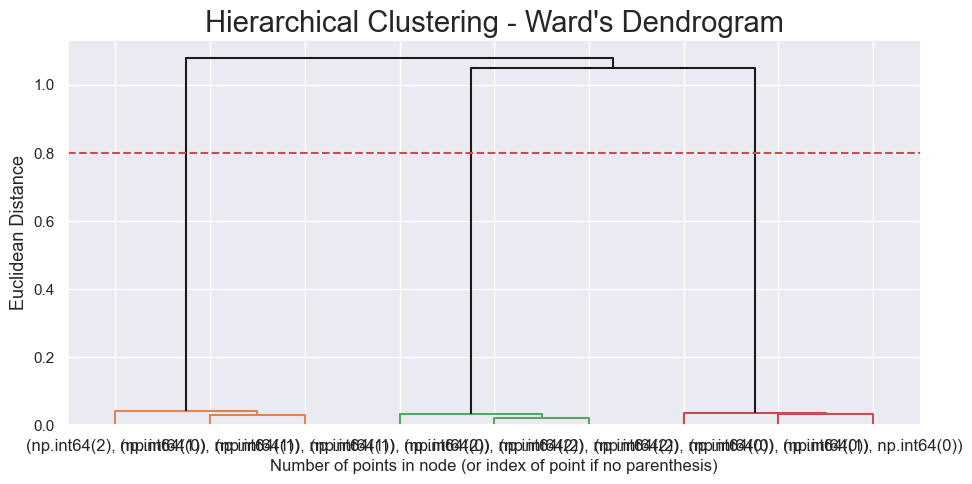

In [23]:
# Using Hierarchical clustering to merge the concatenated cluster centroids
linkage = 'ward'
hclust = AgglomerativeClustering(
    linkage=linkage, 
    metric='euclidean', 
    distance_threshold=0, 
    n_clusters=None
)

hclust_labels = hclust.fit_predict(df_centroids)

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned

y_threshold = 0.8
# y_threshold = 3.3

dendrogram(linkage_matrix, 
           truncate_mode='level', 
           labels=df_centroids.index, p=5, 
           color_threshold=y_threshold, 
           above_threshold_color='k')

plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'Euclidean Distance', fontsize=13)

In [24]:
# Re-running the Hierarchical clustering based on the correct number of clusters
hclust = AgglomerativeClustering(
    linkage='ward', 
    metric='euclidean', 
    n_clusters= 4
)
hclust_labels = hclust.fit_predict(df_centroids)
df_centroids['hclust_labels'] = hclust_labels

df_centroids  # centroid's cluster labels

Customer Lifetime Value  \
VALUE_BASED_CLUSTER LOYALTY_CLUSTER                            
0                   0                               0.074188   
                    1                               0.071821   
                    2                               0.073557   
1                   0                               0.067447   
                    1                               0.072975   
                    2                               0.076200   
2                   0                               0.100979   
                    1                               0.101841   
                    2                               0.093541   

                                     UnredeemedPoints  PointsRedeemedRatio  \
VALUE_BASED_CLUSTER LOYALTY_CLUSTER                                          
0                   0                        0.315863             0.008668   
                    1                        0.399819             0.008816   
                    2                        0.210498             0.008555   
1                   0                        0.337109             0.008065   
                    1                        0.415875             0.008487   
                    2                        0.231130             0.008984   
2                   0                        0.327870             0.008669   
                    1                        0.395803             0.008516   
                    2                        0.209078             0.008804   

                                     KMPerRedeemedPoint  Time on Program  \
VALUE_BASED_CLUSTER LOYALTY_CLUSTER                                        
0                   0                          0.106658         0.385391   
                    1                          0.136785         0.772403   
                    2                          0.072175         0.193032   
1                   0                          0.130852         0.392170   
                    1                          0.155880         0.767440   
                    2                          0.089924         0.194553   
2                   0                          0.121747         0.381582   
                    1                          0.143911         0.778289   
                    2                          0.074576         0.198596   

                                     EnrollmentMonth  hclust_labels  
VALUE_BASED_CLUSTER LOYALTY_CLUSTER                                  
0                   0                       0.189189              0  
                    1                       0.656171              1  
                    2                       0.757335              2  
1                   0                       0.188185              0  
                    1                       0.671630              1  
                    2                       0.749532              2  
2                   0                       0.195049              0  
                    1                       0.675595              3  
                    2                       0.751281              2

In [25]:
df_ = df_no_vip.copy()
# Mapper between concatenated clusters and hierarchical clusters
cluster_mapper = df_centroids['hclust_labels'].to_dict()
cluster_mapper
# Mapping the hierarchical clusters on the centroids to the observations
df_['Merged_Cluster_1'] = df_.apply(
    lambda row: cluster_mapper[
        (row['VALUE_BASED_CLUSTER'], row['LOYALTY_CLUSTER'])
    ], axis=1
)

df_ 

,PointsRedeemedRatio,FlightsWithCompanionsRatio,AvgDistancePerFlight,KMPerRedeemedPoint,UnredeemedPoints,HasBonus,AvgMonthlyFlights,sr_jan,sr_feb,sr_mar,...,LoyaltyStatus,EnrollmentMonth,Time on Program,Cancelled,Reenroll,EnrollmentType,Customer Lifetime Value,VALUE_BASED_CLUSTER,LOYALTY_CLUSTER,Merged_Cluster_1
0,0.011660,0.200000,0.053732,0.101416,0.497569,0.0,0.655977,0.026667,0.040000,0.146667,...,Aurora,0.636364,0.354564,N,0.0,Standard,0.073946,0,2,2
1,0.016634,0.224490,0.031560,0.071096,0.232192,0.0,0.714286,0.077551,0.024490,0.114286,...,Nova,0.181818,0.860852,N,0.0,Standard,0.012155,0,0,0
2,0.003408,0.241706,0.046686,0.347041,0.587235,0.0,0.615160,0.094787,0.000000,0.066351,...,Nova,0.545455,0.358621,N,0.0,Standard,0.011545,1,2,2
3,0.010644,0.157407,0.076975,0.111097,0.361054,0.0,0.314869,0.000000,0.111111,0.027778,...,Star,0.636364,0.503854,N,0.0,Standard,0.027909,0,1,1
4,0.007622,0.276243,0.054122,0.155144,0.491619,0.0,0.527697,0.022099,0.027624,0.165746,...,Star,0.000000,0.736714,N,0.0,Standard,0.058015,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16547,0.000000,0.286822,0.046621,0.000000,0.404377,0.0,0.376093,0.038760,0.085271,0.023256,...,Star,0.363636,0.236511,N,0.0,Standard,0.017084,1,0,0
16548,0.007212,0.187919,0.054790,0.163944,0.417243,0.0,0.434402,0.053691,0.060403,0.000000,...,Star,0.363636,0.239351,N,0.0,Standard,0.072259,0,0,0
16549,0.007880,0.244361,0.041345,0.150075,0.545584,0.0,0.775510,0.101504,0.071429,0.018797,...,Aurora,0.636364,0.793509,N,0.0,Standard,0.096650,2,1,3
16550,0.008188,0.177419,0.047396,0.144404,0.143768,0.0,0.180758,0.000000,0.080645,0.000000,...,Nova,0.909091,0.165923,N,0.0,Standard,0.394720,0,2,2


In [26]:
numerical_columns = df_.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_columns = [col for col in numerical_columns if col != 'VALUE_BASED_CLUSTER' and col != 'LOYALTY_CLUSTER' and col != 'Merged_Cluster_1']
df_.groupby('Merged_Cluster_1').mean(numeric_only=True)[numerical_columns]

,PointsRedeemedRatio,FlightsWithCompanionsRatio,AvgDistancePerFlight,KMPerRedeemedPoint,UnredeemedPoints,HasBonus,AvgMonthlyFlights,sr_jan,sr_feb,sr_mar,...,sr_aug,sr_sep,sr_oct,sr_nov,sr_dec,Income,EnrollmentMonth,Time on Program,Reenroll,Customer Lifetime Value
Merged_Cluster_1,,,,,,,,,,,,,,,,,,,,,
0,0.008573,0.227285,0.045086,0.111517,0.320044,0.025171,0.414643,0.048069,0.046663,0.067316,...,0.097562,0.076635,0.072386,0.066149,0.087102,0.377328,0.189436,0.386196,0.007145,0.074978
1,0.008759,0.237068,0.046443,0.140049,0.402564,0.009474,0.523232,0.062837,0.061390,0.080790,...,0.093715,0.075616,0.069440,0.065569,0.087502,0.376918,0.658813,0.771555,0.000000,0.072018
2,0.008637,0.222325,0.045247,0.075086,0.213614,0.048041,0.276957,0.043504,0.043417,0.052959,...,0.075641,0.073974,0.086103,0.100997,0.157289,0.377841,0.755737,0.193621,0.029201,0.075237
3,0.008516,0.228822,0.046203,0.143911,0.395803,0.005952,0.514343,0.063911,0.062828,0.082011,...,0.101428,0.077743,0.070353,0.066480,0.077268,0.389965,0.675595,0.778289,0.000000,0.101841


In [27]:
# Merge cluster contigency table
# Getting size of each final cluster
df_counts = df_.groupby('Merged_Cluster_1')\
    .size()\
    .to_frame()

df_counts

,0
Merged_Cluster_1,
0,6158
1,4750
2,5308
3,336


In [28]:

df_no_vip["Merged_Cluster_1"] = df_["Merged_Cluster_1"]

In [29]:
df_no_vip.groupby('Merged_Cluster_1')["Income"].agg(["mean", "min","max"])

,mean,min,max
Merged_Cluster_1,,,
0,0.377328,0.0,0.99979
1,0.376918,0.0,1.00000
2,0.377841,0.0,1.00000
3,0.389965,0.0,0.99858


Income is a feature that does not affect our clusters.

Lets check for more features and if they affect each cluster.

In [30]:
cancelled_summary = df_no_vip.groupby('Merged_Cluster_1')['Cancelled'].value_counts(normalize=True).unstack()
print(cancelled_summary)

Cancelled                N         Y
Merged_Cluster_1                    
0                 0.836310  0.163690
1                 0.976632  0.023368
2                 0.790128  0.209872
3                 0.979167  0.020833


We cleary can see that the cluster 3 are the customers who not cancelled, so probably the VIP customers, so that's why we have such a small percentage of Yes in Cancelled. In other hand, we have 24% os customers who cancelled in cluster 0, so customers who probably traveled less.

In [31]:
df_no_vip.columns

Index(['PointsRedeemedRatio', 'FlightsWithCompanionsRatio',
       'AvgDistancePerFlight', 'KMPerRedeemedPoint', 'UnredeemedPoints',
       'HasBonus', 'AvgMonthlyFlights', 'sr_jan', 'sr_feb', 'sr_mar', 'sr_apr',
       'sr_may', 'sr_jun', 'sr_jul', 'sr_aug', 'sr_sep', 'sr_oct', 'sr_nov',
       'sr_dec', 'Province or State', 'Education', 'Income', 'Marital Status',
       'LoyaltyStatus', 'EnrollmentMonth', 'Time on Program', 'Cancelled',
       'Reenroll', 'EnrollmentType', 'Customer Lifetime Value',
       'VALUE_BASED_CLUSTER', 'LOYALTY_CLUSTER', 'Merged_Cluster_1'],
      dtype='object')

In [32]:
education = df_no_vip.groupby('Merged_Cluster_1')['Education'].value_counts(normalize=True).unstack()
print(education)

Education         Bachelor   College    Doctor  High School or Below    Master
Merged_Cluster_1                                                              
0                 0.631211  0.254628  0.039786              0.046931  0.027444
1                 0.617474  0.254526  0.049474              0.046526  0.032000
2                 0.626790  0.252449  0.042012              0.046157  0.032592
3                 0.654762  0.214286  0.056548              0.050595  0.023810


Education is not a significant feature.

In [33]:
Province = df_no_vip.groupby('Merged_Cluster_1')['Province or State'].value_counts(normalize=True).unstack()
Province

Province or State,Alberta,British Columbia,Manitoba,New Brunswick,Newfoundland,Nova Scotia,Ontario,Prince Edward Island,Quebec,Saskatchewan,Yukon
Merged_Cluster_1,,,,,,,,,,,
0,0.064144,0.263397,0.038811,0.036863,0.013803,0.029880,0.325430,0.002273,0.195193,0.023709,0.006496
1,0.054526,0.261895,0.037895,0.040000,0.017263,0.032632,0.323579,0.004421,0.198947,0.022316,0.006526
2,0.058968,0.256971,0.043331,0.037114,0.015637,0.033723,0.319894,0.005463,0.195931,0.026940,0.006029
3,0.056548,0.285714,0.047619,0.044643,0.005952,0.026786,0.327381,0.005952,0.157738,0.026786,0.014881


Province or State do not seem to have a significant relation with the clusters.

# UMAP

c:\Users\calco\anaconda4\envs\dm_project\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\calco\anaconda4\envs\dm_project\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


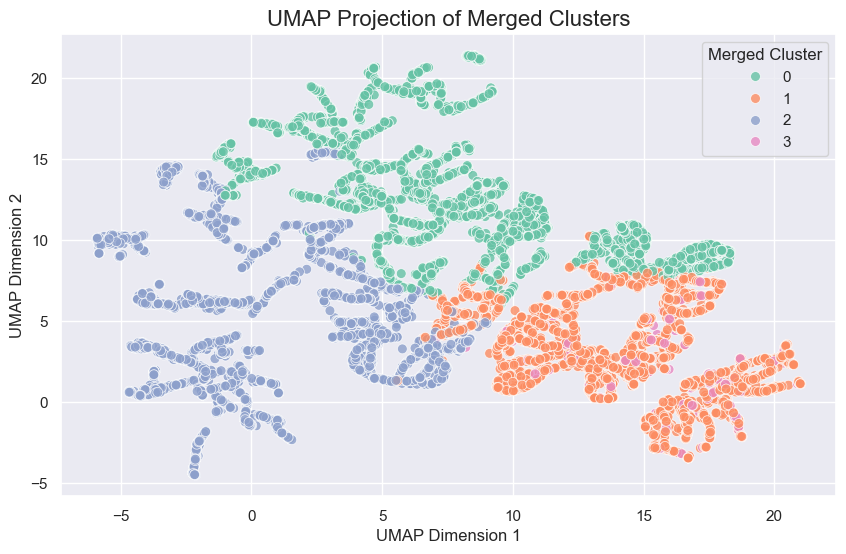

In [34]:
# Make sure to install umap-learn if not already installed
# %pip install umap-learn  # only needed once in the notebook

import umap
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Combine the feature lists used for clustering
col = LO_col + VB_col

# Copy the dataframe
df_ = df_no_vip.copy()

# Select only the clustering features
X = df_[col]

# Initialize and fit UMAP
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X)

# Create a DataFrame for plotting
embedding_df = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])
embedding_df['Merged_Cluster_1'] = df_['Merged_Cluster_1'].values

# Plot UMAP
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=embedding_df,
    x='UMAP1',
    y='UMAP2',
    hue='Merged_Cluster_1',
    palette='Set2',
    s=50,
    alpha=0.8
)
plt.title('UMAP Projection of Merged Clusters', fontsize=16)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend(title='Merged Cluster')
plt.show()


In [35]:
#  UMAP with different n_neighbors
n_neighbors_values = [2, 15, 100]
umap_results = {}

print("Running UMAP with different n_neighbors values\n")

for n_neigh in n_neighbors_values:
    print(f"Computing UMAP with n_neighbors={n_neigh}")
    reducer = umap.UMAP(
        n_components=2,
        n_neighbors=n_neigh,
        min_dist=0.1,
        random_state=42,
        n_jobs=1
    )
    X_umap = reducer.fit_transform(df[col])
    umap_results[n_neigh] = X_umap


Running UMAP with different n_neighbors values

Computing UMAP with n_neighbors=2
Computing UMAP with n_neighbors=15
Computing UMAP with n_neighbors=100


c:\Users\calco\anaconda4\envs\dm_project\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\calco\anaconda4\envs\dm_project\lib\site-packages\umap\spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
c:\Users\calco\anaconda4\envs\dm_project\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\calco\anaconda4\envs\dm_project\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


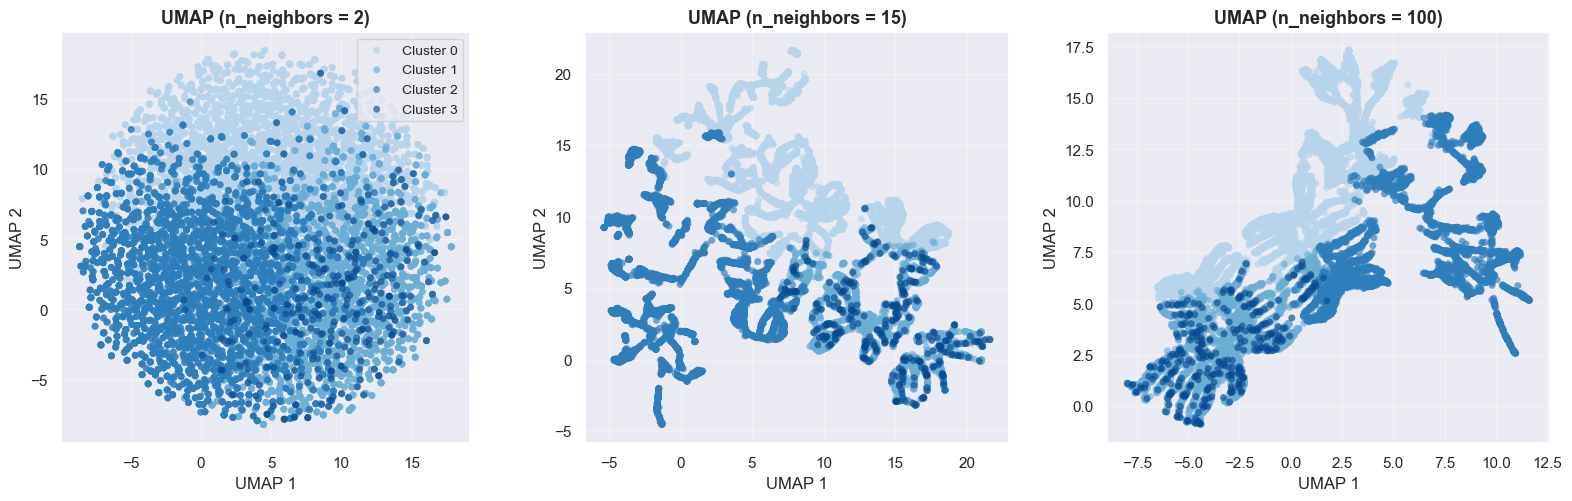

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import umap


X_no_vip = df_no_vip[VB_col + LO_col]

n_neighbors_values = [2, 15, 100]
umap_results = {}

for n in n_neighbors_values:
    reducer = umap.UMAP(
        n_neighbors=n,
        min_dist=0.1,
        random_state=42
    )
    umap_results[n] = reducer.fit_transform(X_no_vip)

cluster_col = 'Merged_Cluster_1'
cluster_labels = sorted(df_no_vip[cluster_col].unique())
n_clusters = len(cluster_labels)

colors = cm.Blues(np.linspace(0.3, 0.9, n_clusters))
label_to_idx = {label: i for i, label in enumerate(cluster_labels)}

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
titles = [
    'UMAP (n_neighbors = 2)',
    'UMAP (n_neighbors = 15)',
    'UMAP (n_neighbors = 100)'
]

for idx, n_neigh in enumerate(n_neighbors_values):
    ax = axes[idx]
    X_umap = umap_results[n_neigh]

    for label in cluster_labels:
        mask = df_no_vip[cluster_col] == label
        ax.scatter(
            X_umap[mask, 0],
            X_umap[mask, 1],
            c=[colors[label_to_idx[label]]],
            s=25,
            alpha=0.65,
            edgecolors='none',
            label=f'Cluster {label}' if idx == 0 else ''
        )

    ax.set_title(titles[idx], fontsize=13, weight='bold')
    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)

axes[0].legend(loc='best', fontsize=10, frameon=True)
plt.tight_layout()
plt.show()


In [37]:
#UMAP with different min_dist
min_dist_values = [0.0, 0.1, 0.99]
umap_mindist_results = {}

print("Running UMAP with different min_dist values...\n")

for min_d in min_dist_values:
    print(f"Computing UMAP with min_dist={min_d}")
    reducer = umap.UMAP(
        n_components=2,
        n_neighbors=15,
        min_dist=min_d,
        random_state=42,
        n_jobs=1
    )
    X_umap = reducer.fit_transform(df_no_vip[col])
    umap_mindist_results[min_d] = X_umap


Running UMAP with different min_dist values...

Computing UMAP with min_dist=0.0
Computing UMAP with min_dist=0.1
Computing UMAP with min_dist=0.99


c:\Users\calco\anaconda4\envs\dm_project\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\calco\anaconda4\envs\dm_project\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\calco\anaconda4\envs\dm_project\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


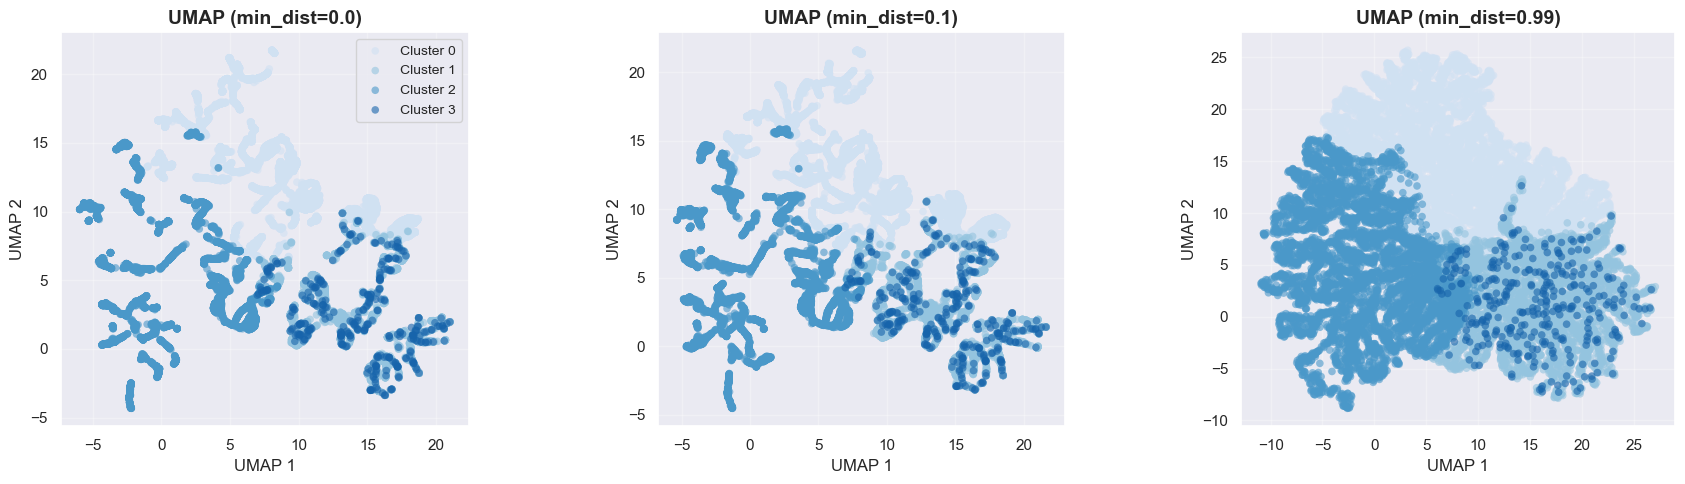

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap

X_no_vip = df_no_vip[VB_col + LO_col]

min_dist_values = [0.0, 0.1, 0.99]
umap_mindist_results = {}

for min_d in min_dist_values:
    reducer = umap.UMAP(n_neighbors=15, min_dist=min_d, random_state=42)
    embedding = reducer.fit_transform(X_no_vip)
    umap_mindist_results[min_d] = embedding

cluster_labels = sorted(df_no_vip['Merged_Cluster_1'].unique())
n_clusters = len(cluster_labels)

# Soft blue palette
palette = sns.color_palette("Blues", n_clusters)

fig, axes = plt.subplots(1, len(min_dist_values), figsize=(18, 5))
titles = ['UMAP (min_dist=0.0)', 'UMAP (min_dist=0.1)', 'UMAP (min_dist=0.99)']

for idx, min_d in enumerate(min_dist_values):
    ax = axes[idx]
    X_umap = umap_mindist_results[min_d]
    for i, label in enumerate(cluster_labels):
        mask = df_no_vip['Merged_Cluster_1'] == label
        ax.scatter(X_umap[mask, 0], X_umap[mask, 1], color=palette[i],
                   alpha=0.6, s=30, edgecolors='none',
                   label=f'Cluster {label}' if idx == 0 else '')
    ax.set_title(titles[idx], fontsize=14, weight='bold')
    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')
    ax.set_aspect(1)
    ax.grid(True, alpha=0.3)

axes[0].legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.show()


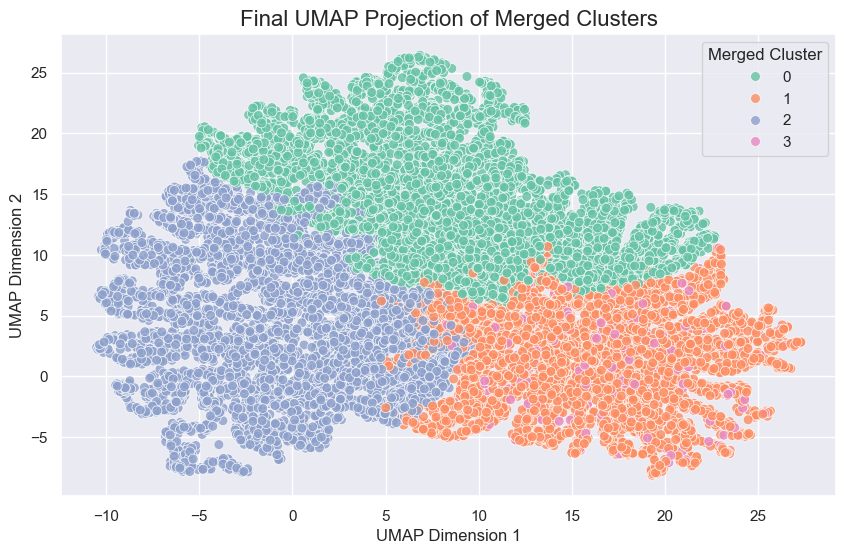

In [39]:
# Now do the final UMAP with chosen parameters (n_neigbors = 15, min_dist=0.1)
reducer = umap.UMAP(
        n_components=2,
        n_neighbors=15,
        min_dist=0.99,
        random_state=42,
        n_jobs=1
)
X_umap_final = reducer.fit_transform(df_no_vip[col])

# Create a DataFrame for plotting
embedding_df_final = pd.DataFrame(X_umap_final, columns=['UMAP1', 'UMAP2'])
embedding_df_final['Merged_Cluster_1'] = df_no_vip['Merged_Cluster_1'].values
# Plot final UMAP
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=embedding_df_final,
    x='UMAP1',
    y='UMAP2',
    hue='Merged_Cluster_1',
    palette='Set2',
    s=50,
    alpha=0.8
)
plt.title('Final UMAP Projection of Merged Clusters', fontsize=16)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend(title='Merged Cluster')
plt.show()


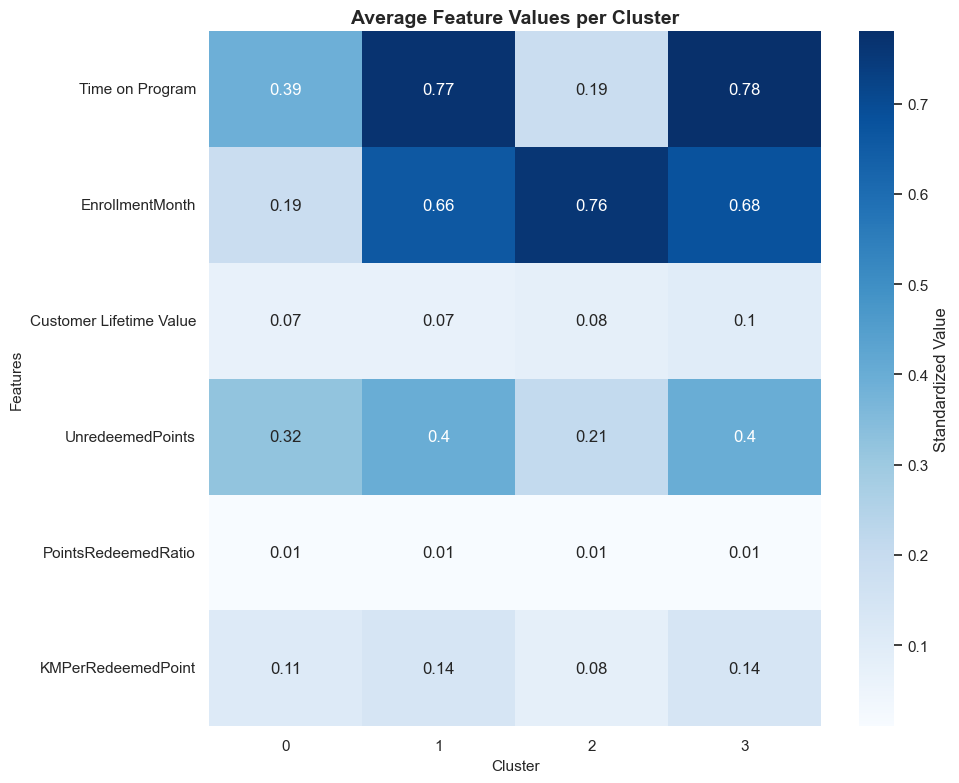

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate mean values per cluster
corr = df_no_vip.groupby('Merged_Cluster_1')[col].mean().round(2)
corr = corr.T

# Single figure with BLUE colormap
plt.figure(figsize=(10, 8))

sns.heatmap(corr, annot=True, cmap='Blues', 
            cbar_kws={'label': 'Standardized Value'})
plt.title('Average Feature Values per Cluster', 
          fontsize=14, weight='bold')
plt.xlabel('Cluster', fontsize=11)
plt.ylabel('Features', fontsize=11)

plt.tight_layout()
plt.show()

c:\Users\calco\anaconda4\envs\dm_project\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


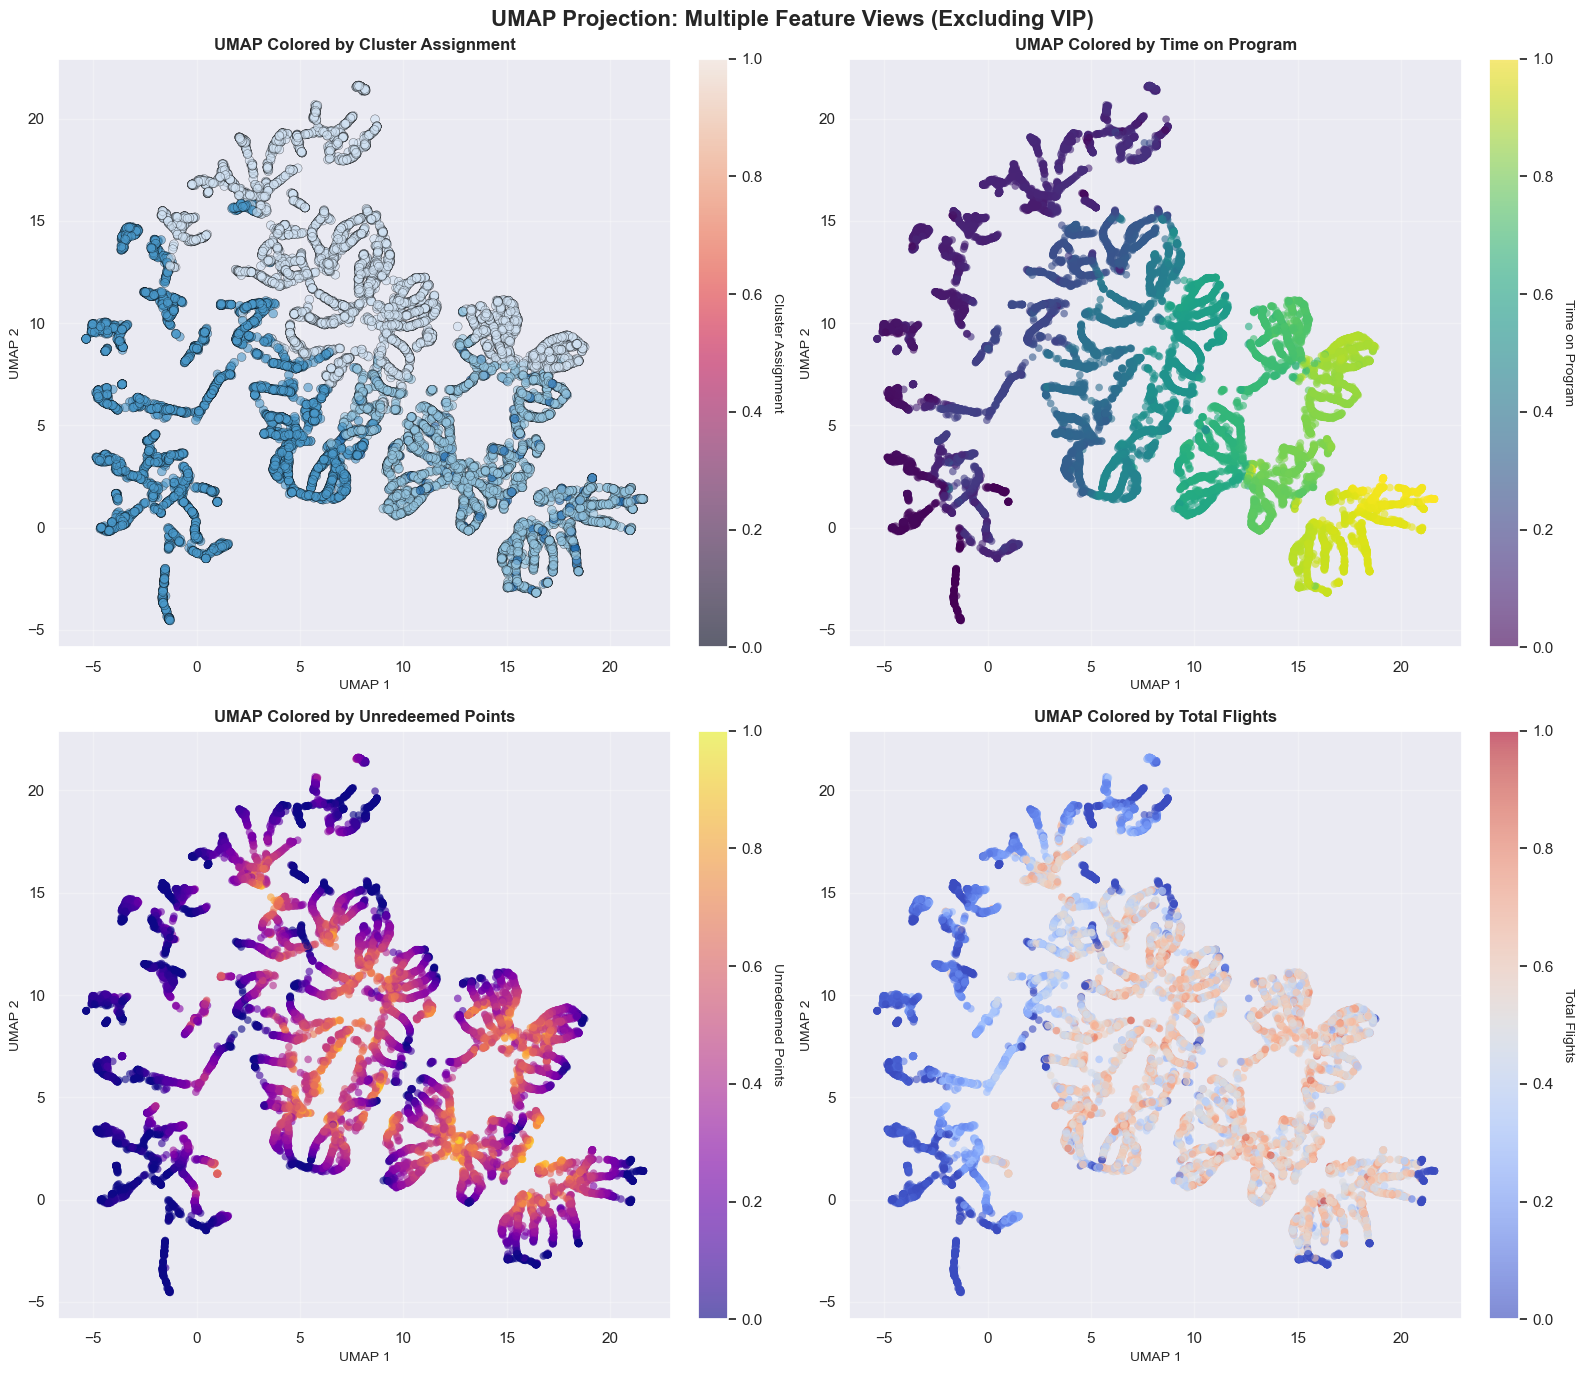

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import matplotlib.cm as cm

X_no_vip = df_no_vip[VB_col + LO_col]

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
X_umap_final = reducer.fit_transform(X_no_vip)
umap_x = X_umap_final[:, 0]
umap_y = X_umap_final[:, 1]

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes_flat = axes.flatten()

features_to_plot = [
    ('Merged_Cluster_1', 'Cluster Assignment', 'tab10'),
    ('Time on Program', 'Time on Program', 'viridis'),
    ('UnredeemedPoints', 'Unredeemed Points', 'plasma'),
    ('AvgMonthlyFlights', 'Total Flights', 'coolwarm')
]

cluster_labels = sorted(df_no_vip['Merged_Cluster_1'].unique())
palette_clusters = sns.color_palette("Blues", len(cluster_labels))
label_to_idx = {label: i for i, label in enumerate(cluster_labels)}

for idx, (feature, label, cmap) in enumerate(features_to_plot):
    ax = axes_flat[idx]
    
    if feature == 'Merged_Cluster_1':
        colors = [palette_clusters[label_to_idx[val]] for val in df_no_vip[feature]]
        scatter = ax.scatter(
            umap_x,
            umap_y,
            c=colors,
            alpha=0.6,
            s=40,
            edgecolors='black',
            linewidths=0.3
        )
    else:
        scatter = ax.scatter(
            umap_x,
            umap_y,
            c=df_no_vip[feature],
            cmap=cmap,
            alpha=0.6,
            s=30,
            edgecolors='none'
        )
    
    ax.set_title(f'UMAP Colored by {label}', fontsize=12, weight='bold')
    ax.set_xlabel('UMAP 1', fontsize=10)
    ax.set_ylabel('UMAP 2', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    cbar = plt.colorbar(scatter, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label(label, fontsize=10, rotation=270, labelpad=15)

plt.suptitle('UMAP Projection: Multiple Feature Views (Excluding VIP)', fontsize=16, weight='bold')
plt.tight_layout()
plt.show()


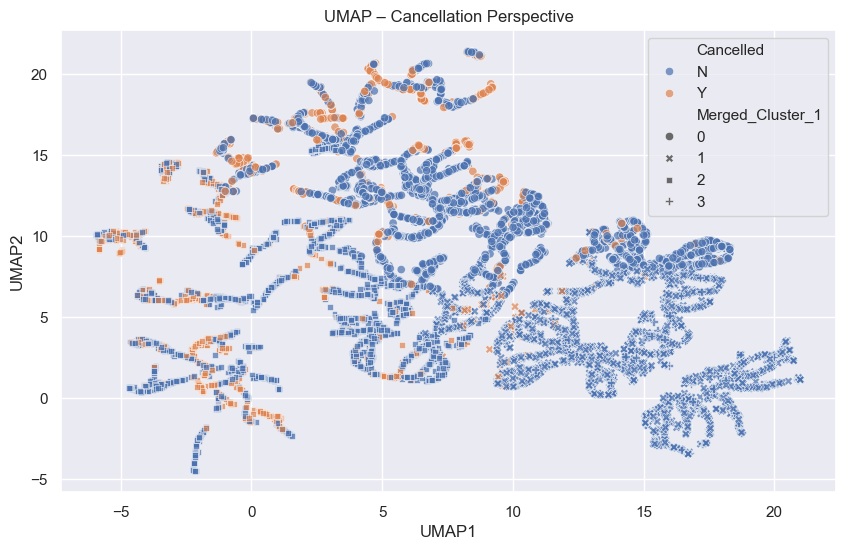

In [42]:
embedding_df['Cancelled'] = df_no_vip['Cancelled'].values

plt.figure(figsize=(10,6))
sns.scatterplot(
    data=embedding_df,
    x='UMAP1',
    y='UMAP2',
    hue='Cancelled',
    style='Merged_Cluster_1',
    alpha=0.7
)
plt.title('UMAP – Cancellation Perspective')
plt.show()

## (LO + VB) + BEHAVIOURAL

In [ ]:
#behavioural = pd.read_csv('ajsnajs.csv')
#behavioural.head()

## UMAP

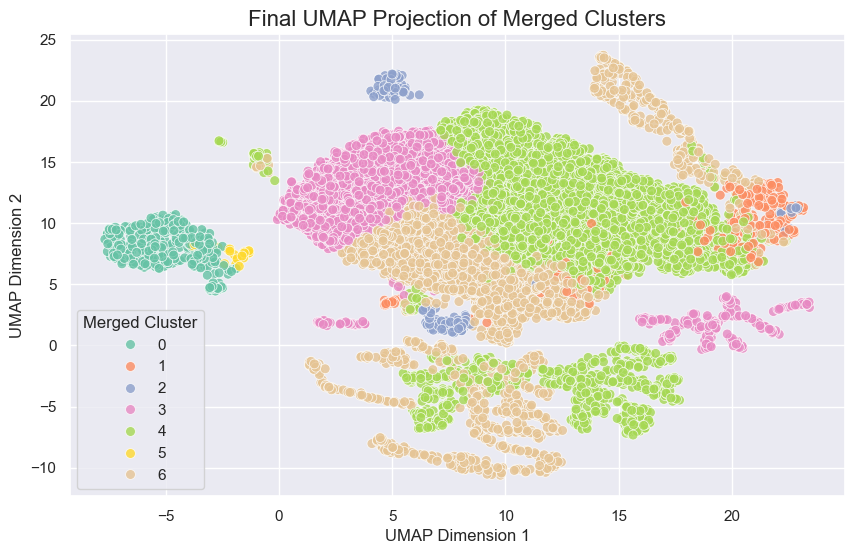

In [ ]:
# Now do the final UMAP with chosen parameters (n_neigbors = 15, min_dist=0.1)
reducer = umap.UMAP(
        n_components=2,
        n_neighbors=15,
        min_dist=0.99,
        random_state=42,
        n_jobs=1
)
X_umap_final = reducer.fit_transform(df_no_vip[col])

# Create a DataFrame for plotting
embedding_df_final = pd.DataFrame(X_umap_final, columns=['UMAP1', 'UMAP2'])
embedding_df_final['Merged_Cluster_2'] = df_no_vip['Merged_Cluster_2'].values
# Plot final UMAP
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=embedding_df_final,
    x='UMAP1',
    y='UMAP2',
    hue='Merged_Cluster_2',
    palette='Set2',
    s=50,
    alpha=0.8
)
plt.title('Final UMAP Projection of Merged Clusters', fontsize=16)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend(title='Merged Cluster')
plt.show()


As we can see from above, sazonality is not a good perspective to merge with the other, so we will analyse after at the end.

We still need Andreia perspective to join here and then start profiiling and UMAP and taking some notes.